In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [3]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [4]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [5]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('1min').mean()

In [6]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [7]:
# def create_sequences(data, seq_length):
#     """
#     Creates sequences and their corresponding target sequences from the input data.

#     Args:
#         data (array-like): The input data.
#         seq_length (int): The length of each sequence.

#     Returns:
#         np.ndarray: Array of input sequences.
#         np.ndarray: Array of target sequences.
#     """
#     if len(data) < 2 * seq_length:
#         raise ValueError("Data length must be at least twice the sequence length.")

#     sequences = []
#     targets = []
    
#     for i in range(len(data) - 2 * seq_length + 1):
#         sequences.append(data[i:i+seq_length])               # Input sequence
#         targets.append(data[i+seq_length:i+2*seq_length])    # Target sequence of same length
    
#     return np.array(sequences), np.array(targets)


In [8]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """
    target_length = seq_length // 3  # Target is half the size of the training sequence

    if len(data) < seq_length + target_length:
        raise ValueError("Data length must be at least seq_length + target_length.")

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length - target_length + 1):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length:i+seq_length+target_length]) # Target sequence

    return np.array(sequences), np.array(targets)


In [9]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece
# val_df1 = first_piece[int(n*0.4):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
# val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 90)
# val_seq1, val_labels1 = create_sequences(val_df1.values, 60)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device='cuda') # (batch, output_dim)
# val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
# val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='cuda')  # (batch, output_dim)


In [10]:
train_seq_tensor1.shape

torch.Size([842, 90, 1])

In [11]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 90)
val_seq2, val_labels2 = create_sequences(val_df2.values, 90)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device='cuda') # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device='cuda')  # (batch, output_dim)

In [12]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 90)
val_seq3, val_labels3 = create_sequences(val_df3.values, 90)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [13]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 90)
val_seq4, val_labels4 = create_sequences(val_df4.values, 90)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device='cuda') # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device='cuda')  # (batch, output_dim)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[:, -30:, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cuda")  # Use "cuda" if you have a GPU

model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.8)

criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
criterion3 = nn.SmoothL1Loss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

In [15]:
# Train model 1
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    y_pred = model1(train_seq_tensor1)
    # print(y_pred.shape)
    # print(train_label_tensor1.shape)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    # model1.eval()
    # with torch.no_grad():
    #     y_val = model1(val_seq_tensor1)
    #     val_loss = criterion1(y_val, val_label_tensor1)
    #     val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.480040043592453
Epoch 10, Train Loss: 0.4677751660346985
Epoch 20, Train Loss: 0.4424395263195038
Epoch 30, Train Loss: 0.35451653599739075
Epoch 40, Train Loss: 0.16837595403194427
Epoch 50, Train Loss: 0.1425476372241974
Epoch 60, Train Loss: 0.12135464698076248
Epoch 70, Train Loss: 0.11862145364284515
Epoch 80, Train Loss: 0.11708036065101624
Epoch 90, Train Loss: 0.11542529612779617
Epoch 100, Train Loss: 0.11444858461618423
Epoch 110, Train Loss: 0.1135919839143753
Epoch 120, Train Loss: 0.11271023750305176
Epoch 130, Train Loss: 0.11183210462331772
Epoch 140, Train Loss: 0.11092901974916458
Epoch 150, Train Loss: 0.10997150838375092
Epoch 160, Train Loss: 0.10892322659492493
Epoch 170, Train Loss: 0.10773533582687378
Epoch 180, Train Loss: 0.10633611679077148
Epoch 190, Train Loss: 0.10464557260274887
Epoch 200, Train Loss: 0.10258391499519348
Epoch 210, Train Loss: 0.10002653300762177
Epoch 220, Train Loss: 0.09673678874969482
Epoch 230, Train Loss: 0.092

In [16]:
train_label_tensor1.shape

torch.Size([842, 30, 1])

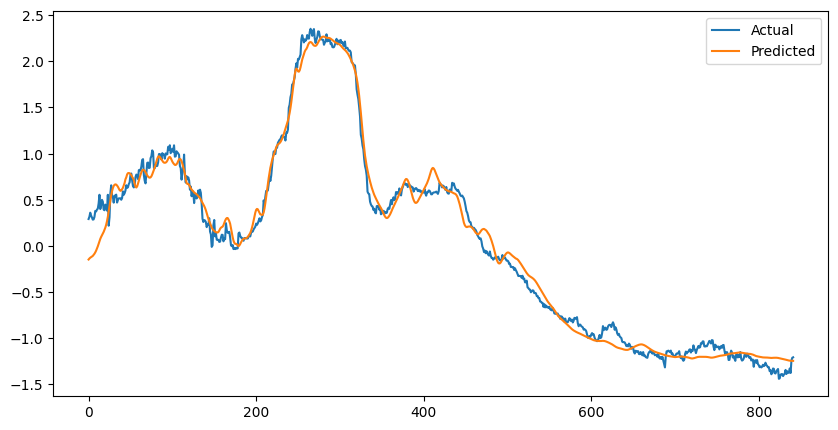

In [17]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(train_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor1[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()


In [18]:
# Train model 2
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion2(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.4390607476234436, Val Loss: 1.5699180364608765
Epoch 10, Train Loss: 0.42765262722969055, Val Loss: 1.5808510780334473
Epoch 20, Train Loss: 0.40282565355300903, Val Loss: 1.5349475145339966
Epoch 30, Train Loss: 0.3111676275730133, Val Loss: 1.2920950651168823
Epoch 40, Train Loss: 0.1764640361070633, Val Loss: 0.5962162613868713
Epoch 50, Train Loss: 0.14443597197532654, Val Loss: 0.07159513980150223
Epoch 60, Train Loss: 0.12730427086353302, Val Loss: 0.16581745445728302
Epoch 70, Train Loss: 0.12302538007497787, Val Loss: 0.06631647795438766
Epoch 80, Train Loss: 0.12142135202884674, Val Loss: 0.10942693054676056
Epoch 90, Train Loss: 0.1202387809753418, Val Loss: 0.12016315013170242
Epoch 100, Train Loss: 0.11909452825784683, Val Loss: 0.11103709042072296
Epoch 110, Train Loss: 0.11803536117076874, Val Loss: 0.10186836123466492
Epoch 120, Train Loss: 0.11704053729772568, Val Loss: 0.09805542230606079
Epoch 130, Train Loss: 0.11599767208099365, Val Loss: 0.09

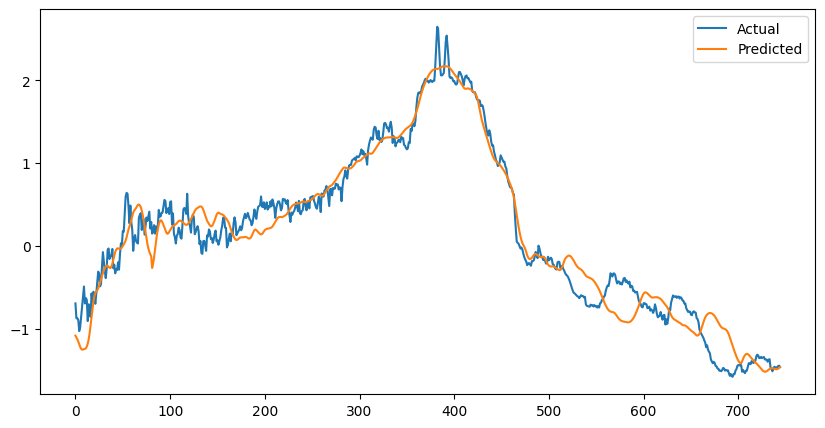

In [19]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(train_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor2[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()

In [20]:
# Train model 3
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer3.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion3(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.4583156406879425, Val Loss: 0.668704092502594
Epoch 10, Train Loss: 0.44234490394592285, Val Loss: 0.7104740738868713
Epoch 20, Train Loss: 0.4157010018825531, Val Loss: 0.7386459112167358
Epoch 30, Train Loss: 0.34079426527023315, Val Loss: 0.7063691020011902
Epoch 40, Train Loss: 0.23705950379371643, Val Loss: 0.35298600792884827
Epoch 50, Train Loss: 0.16981659829616547, Val Loss: 0.016939539462327957
Epoch 60, Train Loss: 0.1601148247718811, Val Loss: 0.0615069605410099
Epoch 70, Train Loss: 0.15576235949993134, Val Loss: 0.05771736800670624
Epoch 80, Train Loss: 0.1504916101694107, Val Loss: 0.0359155535697937
Epoch 90, Train Loss: 0.14752420783042908, Val Loss: 0.04539159685373306
Epoch 100, Train Loss: 0.14526937901973724, Val Loss: 0.044850658625364304
Epoch 110, Train Loss: 0.14287805557250977, Val Loss: 0.03975300118327141
Epoch 120, Train Loss: 0.1404215395450592, Val Loss: 0.04054895415902138
Epoch 130, Train Loss: 0.1378534883260727, Val Loss: 0.0384

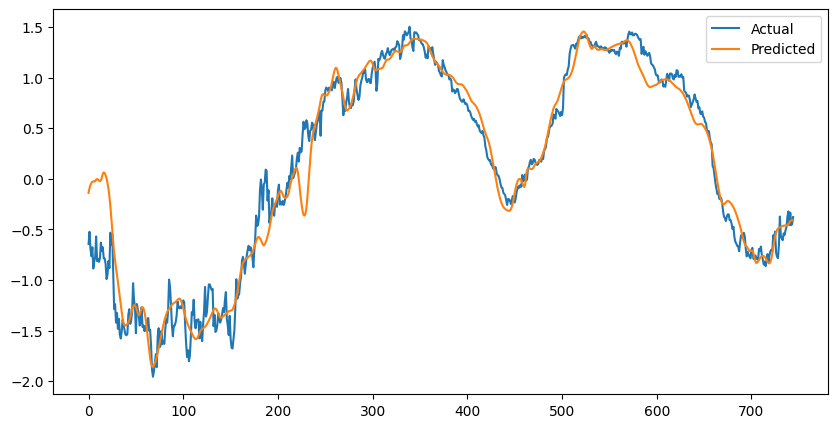

In [21]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(train_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor3[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()


In [22]:
# import copy
# # Average the models
# average_model = copy.deepcopy(model1)
# models = [model1, model2, model3]
# # Compute the average of the parameters
# with torch.no_grad():
#     for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
#         avg_param = sum(params) / len(models)  # Element-wise average
#         params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# # The `average_model` now has the averaged parameters

In [36]:
sd1 = model1.state_dict()
sd2 = model2.state_dict()
sd3 = model3.state_dict()
avg_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
avg_model = avg_model.to(device='cuda')
sd_avg = avg_model.state_dict()
for key in sd1:
    sd_avg[key] = (sd1[key] + sd2[key] + sd3[key])/3

avg_model.load_state_dict(sd_avg)

<All keys matched successfully>

In [41]:
print("Model 1 first LSTM weight_ih_l0:\n", sd1["lstm.weight_ih_l0"][0][:10])
print("Model 2 first LSTM weight_ih_l0:\n", sd2["lstm.weight_ih_l0"][0][:10])
print("Model 3 first LSTM weight_ih_l0:\n", sd3["lstm.weight_ih_l0"][0][:10])

print("Avg model first LSTM weight_ih_l0:\n", sd_avg["lstm.weight_ih_l0"][0][:10])


Model 1 first LSTM weight_ih_l0:
 tensor([0.0135], device='cuda:0')
Model 2 first LSTM weight_ih_l0:
 tensor([0.0602], device='cuda:0')
Model 3 first LSTM weight_ih_l0:
 tensor([0.0427], device='cuda:0')
Avg model first LSTM weight_ih_l0:
 tensor([0.0388], device='cuda:0')


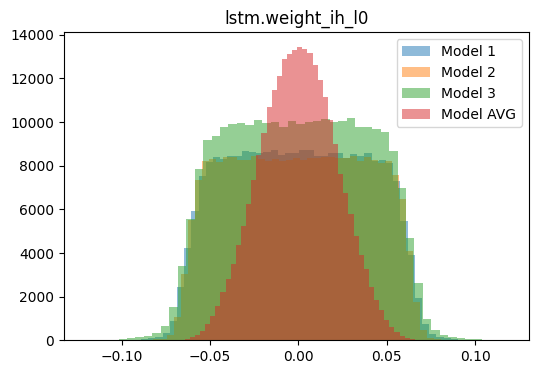

In [46]:
w1 = sd1["lstm.weight_hh_l0"].view(-1).cpu().numpy()  # flatten
w2 = sd2["lstm.weight_hh_l0"].view(-1).cpu().numpy()  # flatten
w3 = sd3["lstm.weight_hh_l0"].view(-1).cpu().numpy() #flatten
w4 = sd_avg["lstm.weight_hh_l0"].view(-1).cpu().numpy() #flatten
plt.figure(figsize=(6, 4))
plt.hist(w1, bins=50, alpha=0.5, label='Model 1')
plt.hist(w2, bins=50, alpha=0.5, label='Model 2')
plt.hist(w3, bins=50, alpha=0.5, label='Model 3')
plt.hist(w4, bins=50, alpha=0.5, label='Model AVG')
plt.legend()
plt.title("lstm.weight_ih_l0")
plt.show()

In [37]:
# Normalize the data (each partition separately)
test_mean4 = (train_mean1 + train_mean2 + train_mean3 + train_mean4)/4
test_std = (train_std1 + train_std2 + train_std3 + train_std4)/4
test_df = fourth_piece
test_df = (test_df - test_mean4)/test_std

In [38]:
test_seq4, test_labels4 = create_sequences(test_df.values, 90)
test_tensor_seq4 = torch.FloatTensor(test_seq4).to(device='cuda')
test_tensor_labels4 = torch.FloatTensor(test_labels4).to(device='cuda')

In [39]:
test_tensor_labels4.shape

torch.Size([722, 30, 1])

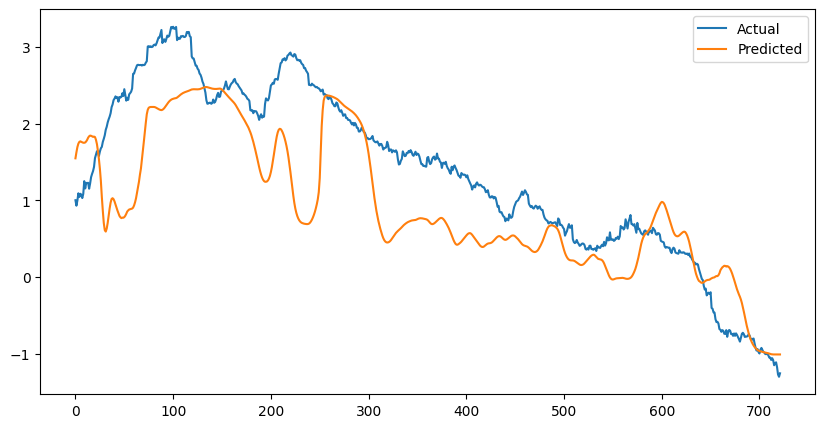

In [47]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

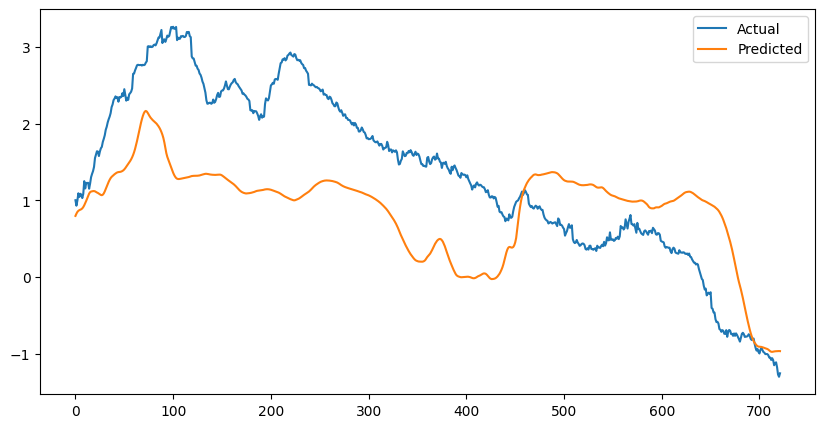

In [48]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

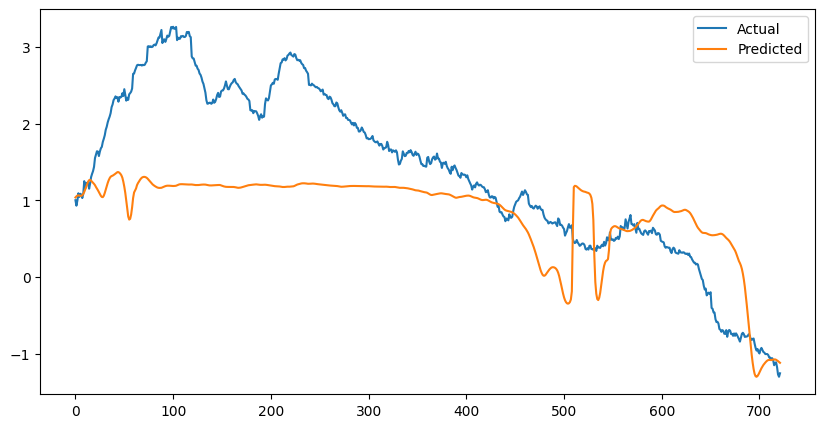

In [49]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

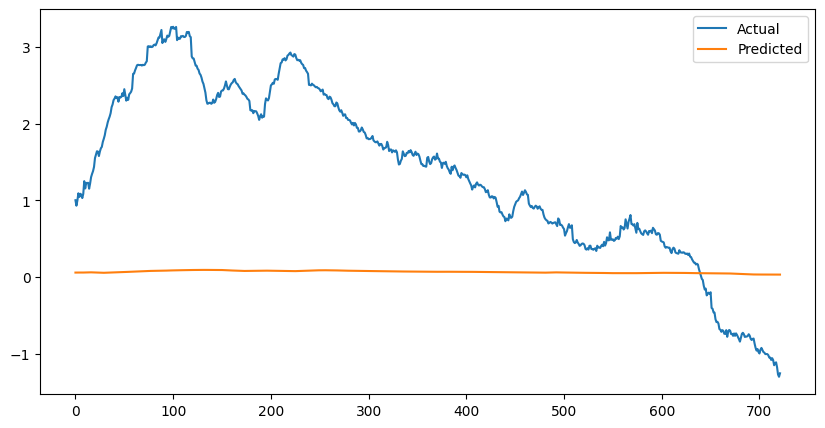

In [40]:
avg_model.eval()
with torch.no_grad():
    y_pred_test = avg_model(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

In [28]:
# # model 2 and 3 only
# import copy
# # Average the models
# average_model = copy.deepcopy(model3)
# models = [model3, model2]
# # Compute the average of the parameters
# with torch.no_grad():
#     for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
#         avg_param = sum(params) / len(models)  # Element-wise average
#         params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# # The `average_model` now has the averaged parameters
# average_model.eval()
# with torch.no_grad():
#     y_pred_test = average_model(test_tensor_seq4)

# # Plot test predictions
# plt.figure(figsize=(10, 5))
# plt.plot(test_tensor_labels4[:, 1,:].cpu().numpy(), label="Actual")
# plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
# plt.legend()


In [29]:
# average_model.eval()
# with torch.no_grad():
#     y_pred_test = average_model(test_tensor_seq4)

# # Plot test predictions
# plt.figure(figsize=(10, 5))
# plt.plot(test_tensor_labels4[0, :,:].cpu().numpy(), label="Actual")
# plt.plot(y_pred_test[0, :, :].cpu().numpy(), label="Predicted")
# plt.legend()
# plt.savefig('model123_avg_fl')

In [30]:
test_tensor_labels4.shape

torch.Size([722, 30, 1])